In [1]:
from jax import config
import jax.numpy as np
from DMA_MR_ss import dma_mr_uncertain_pressures
import matplotlib.pyplot as plt
from opyrability import implicit_map

In [2]:
config.update("jax_enable_x64", True)

In [3]:
theta = np.linspace(0, 2 * np.pi, 225)
phi = -np.pi / 3
a, b= 6e4, 7.5e4
h, k = 101325  , 101325
y1 = h +  (a * np.cos(theta) * np.cos(phi) - b * np.sin(theta) * np.sin(phi))  
y2 = k +  (b * np.sin(theta) * np.cos(phi) + a * np.cos(theta) * np.cos(phi))

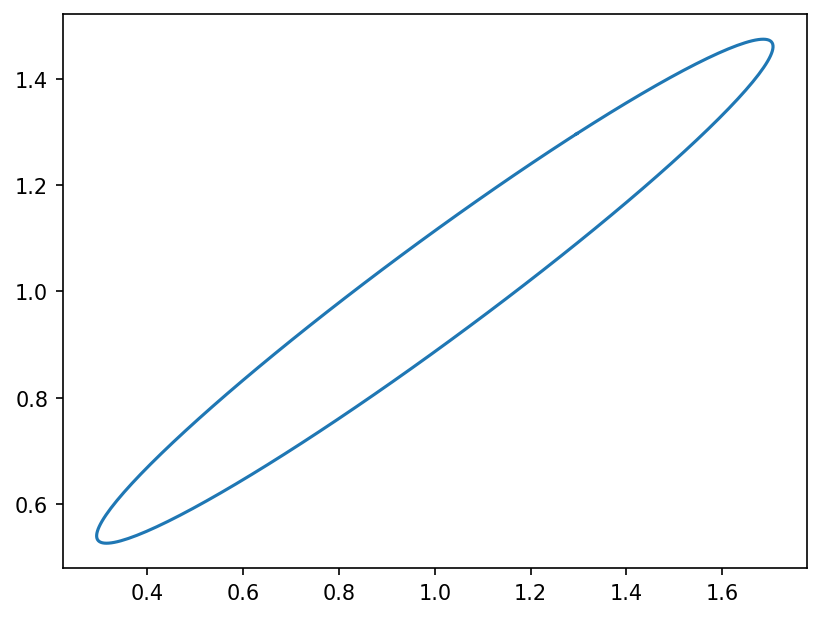

In [4]:
import matplotlib.ticker as ticker

AIS_PTS=np.array([y1,y2]).T
fig, ax = plt.subplots()
ax.plot(AIS_PTS[:,0]/101325, AIS_PTS[:,1]/101325)

# Disable scientific notation on both axes
ax.xaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False, useMathText=False))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False, useMathText=False))

# Ensure tick labels are in plain format
ax.ticklabel_format(style='plain', axis='both')

plt.show()


In [5]:
output_init = np.array([15, 15])

In [6]:
AIS, AOS, AIS_poly, AOS_poly = implicit_map(dma_mr_uncertain_pressures,  
                                        output_init,
                                        continuation='Explicit Euler',
                                        domain_points=AIS_PTS,
                                        validation='predictor-corrector')

Forward Mapping Selected.
The given domain is recognized as an Available Input Set (AIS).
The result of this mapping is an Achievable Output Set(AOS)
Selected Euler


100%|██████████| 225/225 [00:33<00:00,  6.80it/s]


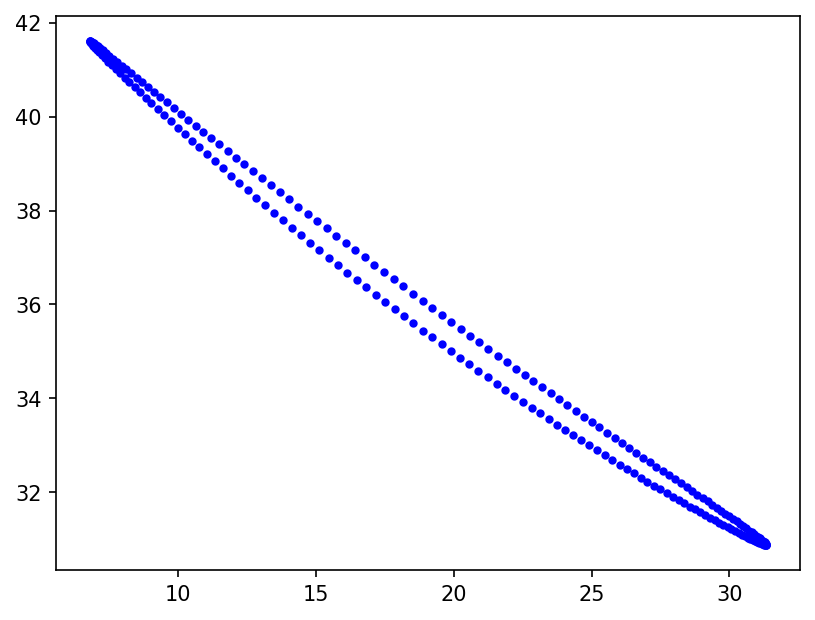

In [7]:
AOS_PTS = AOS.reshape(-1,2)
plt.figure()
plt.plot(AOS_PTS[1:,0], AOS_PTS[1:,-1], 'b.')

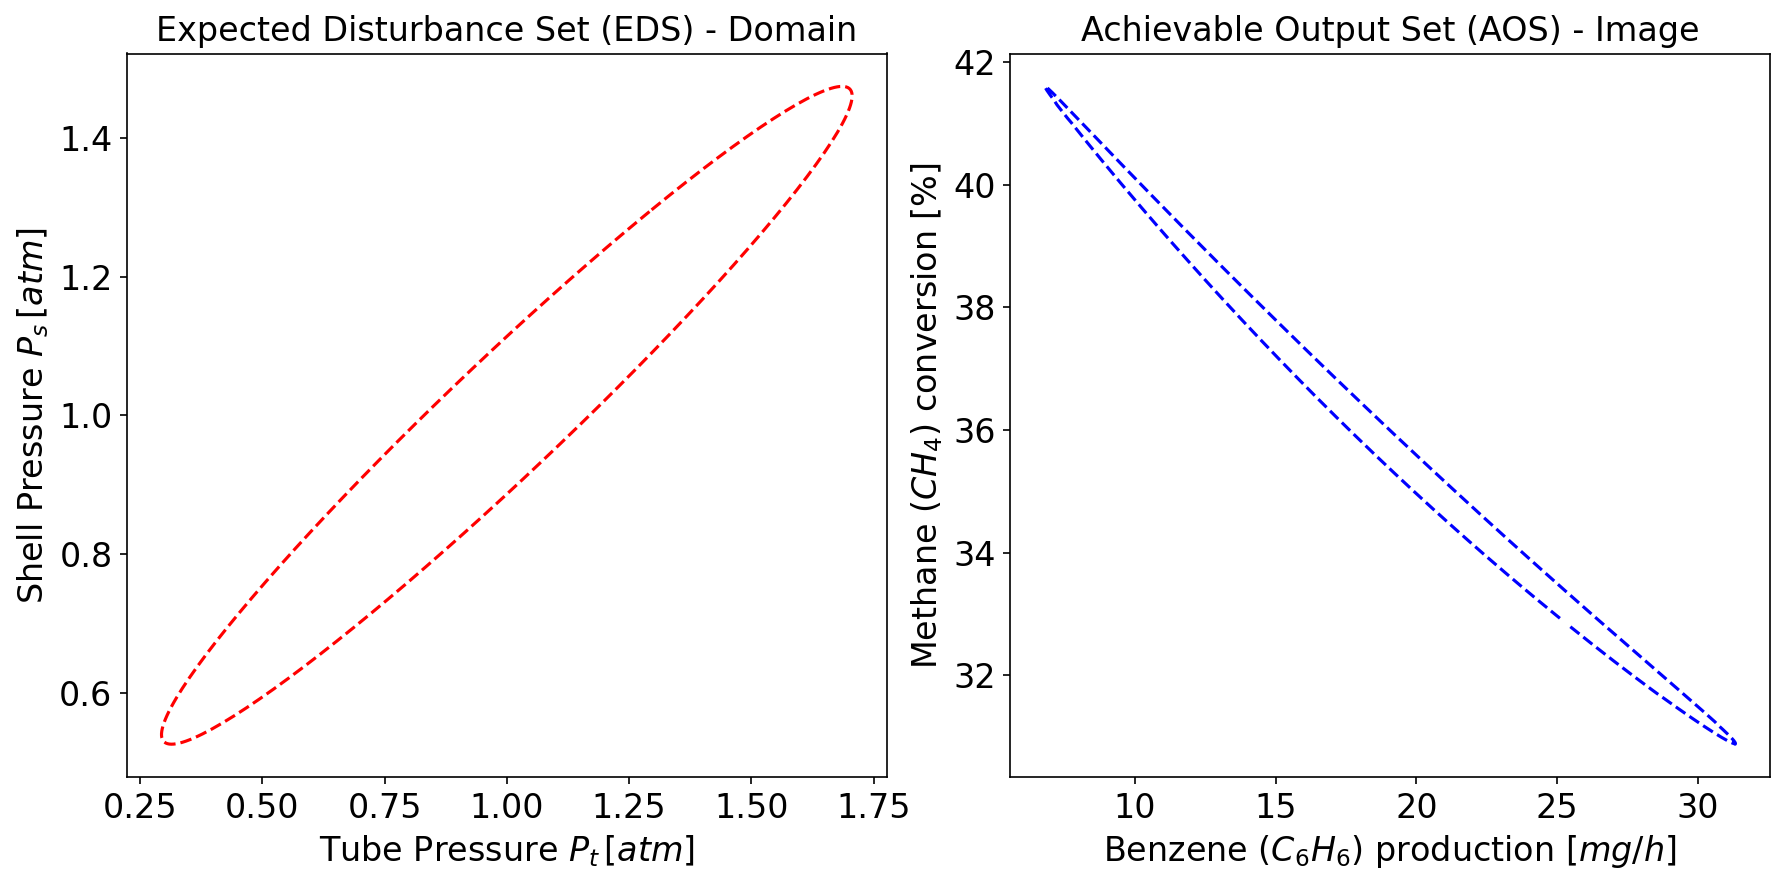

In [8]:
# Plotting the input ellipse for Pressures
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot for Expected Disturbance Set (EDS)
ax1.plot(AIS_PTS[:, 0] / 101325, AIS_PTS[:, 1] / 101325, 'r--')
ax1.set_title('Expected Disturbance Set (EDS) - Domain', fontsize=16)
ax1.set_xlabel('Tube Pressure $P_t \,[atm] $', fontsize=16)
ax1.set_ylabel('Shell Pressure $P_s \,[atm]$', fontsize=16)

# Plot for Achievable Output Set (AOS)
ax2.plot(AOS_PTS[1:, 0], AOS_PTS[1:, 1], 'b--')
ax2.set_title('Achievable Output Set (AOS) - Image', fontsize=16)
ax2.set_xlabel('Benzene $(C_6 H_6)$ production $[mg/h]$', fontsize=16)
ax2.set_ylabel('Methane $(CH_4)$ conversion $[\%]$', fontsize=16)

# Set consistent tick font sizes
for ax in [ax1, ax2]:
    ax.tick_params(axis='both', which='both', labelsize=16)  # Consistent fontsize for ticks

# Apply tight layout
plt.tight_layout()

# Save the figure
# plt.savefig("dma_implicit_forward.eps", format="pdf", bbox_inches="tight")

Performing the inverse mapping of this problem to show that it matches with what was obtained through the forward uncertainty mapping.

1) Initial Estimate of 1atm for shell and tube pressures

In [9]:
input_init =  np.array([101325, 101325])

2) Running inverse uncertainty mapping with the Image points (AOS) previously obtained to map the EDS back and check:

In [10]:
AOS2, EDS, _, _ = implicit_map(dma_mr_uncertain_pressures,  
                                        input_init,
                                        continuation='Explicit Euler',
                                        domain_points=AOS_PTS,
                                        direction='inverse')

Inverse Mapping Selected.
The given domain is recognized as Desired Output Set (DOS).
The result of this mapping is an Desired Input Set(DIS)
Selected Euler


100%|██████████| 225/225 [00:33<00:00,  6.69it/s]


3) Plotting against the original EDS formulated using the ellipse parametric equation

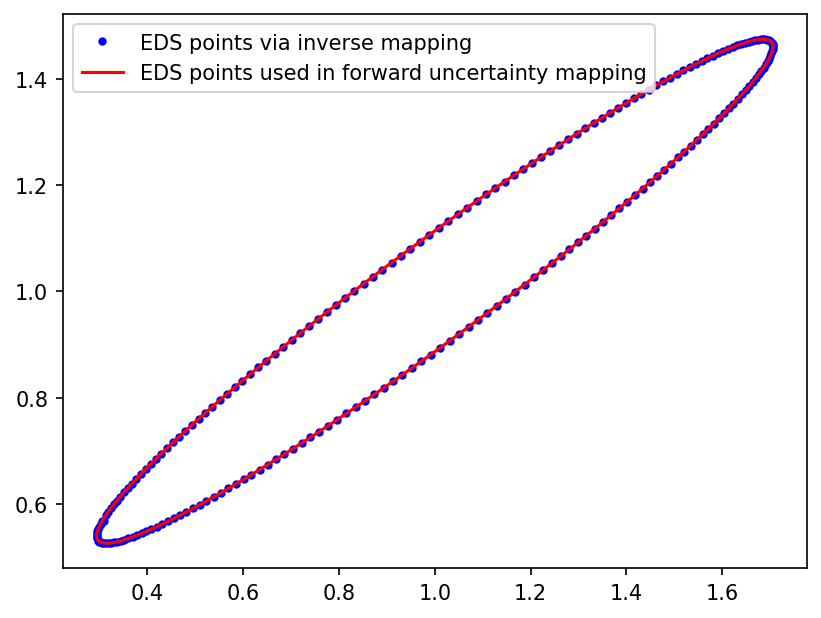

In [11]:
EDS_PTS = EDS.reshape(-1,2)
plt.figure()
plt.plot(EDS_PTS[1:,0]/101325, EDS_PTS[1:,-1]/101325, 'b.', label='EDS points via inverse mapping')
plt.plot(AIS_PTS[:,0]/101325, AIS_PTS[:,1]/101325, 'r-',label='EDS points used in forward uncertainty mapping')
plt.legend()


They match, as they should be.